## Noninear Regression using a Neural Network with Pytorch

In [1]:
%matplotlib inline
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d
import torch

Load data from file

In [2]:
data=np.load('data_nonlinear_regression.npy', allow_pickle=True)
data=data.item()
data.keys()

dict_keys(['X_train', 'Y_train', 'X_val', 'Y_val', 'X_test', 'Y_test'])

In [3]:
type(data)

dict

In [4]:
X_train=data['X_train']
Y_train=data['Y_train']
X_val=data['X_val']
Y_val=data['Y_val']
X_test=data['X_test']
Y_test=data['Y_test']

Text(0.5, 0, 'Y')

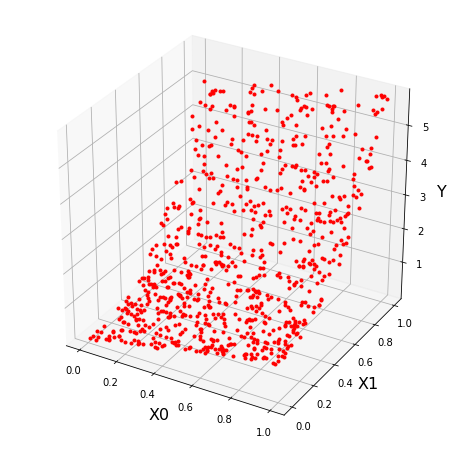

In [5]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot(X_train[:,0], X_train[:,1], Y_train.squeeze(), 'r.')
ax.set_xlabel('X0', fontsize=16)
ax.set_ylabel('X1', fontsize=16)
ax.set_zlabel('Y', fontsize=16)

define a dataset to hold/represent the data <br>
`MyDataset` is a Python class, derived from `torch_dataset`

In [6]:
from torch.utils.data import Dataset as torch_dataset
class MyDataset(torch_dataset):
    def __init__(self, X, Y):
        self.X=X
        self.Y=Y
    def __len__(self):
        #return the number of data points
        return self.X.shape[0]
    def __getitem__(self, idx):        
        # use the notation DatasetName[idx]
        # to get a data point (x,y) by idx
        # we need to convert numpy array to torch tensor
        x=torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

Create instance objects of the `MyDataset` class <br>
a training dataset `dataset_train` <br>
a validation dataset `dataset_val` <br>
a testing dataset `dataset_test` <br>

In [7]:
dataset_train = MyDataset(X_train, Y_train)
dataset_val = MyDataset(X_val, Y_val)
dataset_test = MyDataset(X_test, Y_test)

In [8]:
dataset_train[0] # get the first data point in the traning set

(tensor([0.5488, 0.7152, 0.6028]), tensor([2.6730]))

In [9]:
len(dataset_train) # get the number of data points in the training set

800

create dataloaders which will be used to generate minibatches <br>
batch_size=64 means each minibatch contains 64 data points  <br>
note: the last minibatch may contain less than 64 data points

In [10]:
from torch.utils.data import DataLoader as torch_dataloader
dataloader_train = torch_dataloader(dataset_train, batch_size=64, shuffle=True, num_workers=0)
dataloader_val = torch_dataloader(dataset_val, batch_size=64, shuffle=False, num_workers=0) 
dataloader_test = torch_dataloader(dataset_test, batch_size=64, shuffle=False, num_workers=0) 

In [11]:
dataloader_train.dataset[0] # get the first data point in the training set

(tensor([0.5488, 0.7152, 0.6028]), tensor([2.6730]))

In [12]:
len(dataloader_train) # get the number of minibatches

13

We can use a dataloader to generate minibatches 

In [13]:
for epoch in range(0, 1): # change 1 to 100 if we need to train the model for 100 epochs
    for batch_idx, (X, Y) in enumerate(dataloader_train):
        print(batch_idx, X.size(), Y.size())

0 torch.Size([64, 3]) torch.Size([64, 1])
1 torch.Size([64, 3]) torch.Size([64, 1])
2 torch.Size([64, 3]) torch.Size([64, 1])
3 torch.Size([64, 3]) torch.Size([64, 1])
4 torch.Size([64, 3]) torch.Size([64, 1])
5 torch.Size([64, 3]) torch.Size([64, 1])
6 torch.Size([64, 3]) torch.Size([64, 1])
7 torch.Size([64, 3]) torch.Size([64, 1])
8 torch.Size([64, 3]) torch.Size([64, 1])
9 torch.Size([64, 3]) torch.Size([64, 1])
10 torch.Size([64, 3]) torch.Size([64, 1])
11 torch.Size([64, 3]) torch.Size([64, 1])
12 torch.Size([32, 3]) torch.Size([32, 1])


We can see that each of the first 12 minibatches contains 64 data points <br>
The last minibatch contains less than 64 data points

Now, let's build a neural network that has two hidden layers and nonlinear activation - softplus

In [14]:
import torch.nn as nn
import torch.nn.functional as nnF
class Net(nn.Module):
    def __init__(self, input_dim, output_dim, n_units):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units)
        self.layer2 = nn.Linear(n_units, n_units)
        self.layer3 = nn.Linear(n_units, output_dim)        
    def forward(self, x):
        x=self.layer1(x)
        x=nnF.softplus(x)
        x=self.layer2(x)
        x=nnF.softplus(x)
        y=self.layer3(x)
        return y

create an instance object of the class

In [15]:
model=Net(input_dim=3, output_dim=1, n_units=16)

In [16]:
#move the model to GPU if you have a GPU
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (layer1): Linear(in_features=3, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
)

In [17]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.3210,  0.5214, -0.1180],
         [-0.1283, -0.2534, -0.5394],
         [-0.4457, -0.1349,  0.5213],
         [-0.0758,  0.3132,  0.3880],
         [-0.1546, -0.2993,  0.2303],
         [-0.3754, -0.4382, -0.0554],
         [ 0.3986, -0.2507, -0.5307],
         [ 0.1792,  0.0928, -0.5398],
         [-0.5327,  0.3762, -0.1127],
         [-0.2421,  0.4990, -0.4365],
         [-0.4921,  0.1849, -0.5364],
         [-0.2903,  0.0141,  0.3222],
         [-0.2951, -0.2082,  0.1162],
         [ 0.4573, -0.1382, -0.5721],
         [-0.3205,  0.1552,  0.1031],
         [ 0.1236, -0.3539, -0.0374]], requires_grad=True),
 Parameter containing:
 tensor([-0.4325,  0.4552, -0.4349, -0.4844, -0.4714,  0.0989, -0.0564, -0.4753,
         -0.3963, -0.3888, -0.2454, -0.1487, -0.2258, -0.2073, -0.4652,  0.5321],
        requires_grad=True),
 Parameter containing:
 tensor([[ 0.1556, -0.0154,  0.0804,  0.1897,  0.0485,  0.0709,  0.2087,  0.1477,
           0.0523, -0.1268,

create an optimizer that does stochastic gradient descent <br>
send the parameters of the linear_model to the optimizer

In [18]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

define a function to train the neural network in one epoch

In [19]:
def train(model, optimizer, dataloader, device, epoch):    
    model.train()#set model to train mode
    loss_train=0
    for batch_idx, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()#clear the grad of each parameter
        Yp = model(X)#forward pass
        loss = torch.mean((Yp-Y)**2) # MSE loss or other loss
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()
        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * X.size(0), len(dataloader.dataset),
                    100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    return loss_train

define a function to evaluate the neural network on the validation set or the testing set

In [20]:
def test(model, dataloader, device):
    model.eval()#set model to evaluation mode
    loss_test=0
    mae_test=0
    sample_count=0
    with torch.no_grad(): # tell Pytorch not to build graph in the 'with' section
        for batch_idx, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            Yp = model(X)#forward pass
            loss_test+=torch.sum((Yp-Y)**2).item()
            mae_test+= torch.sum((Yp-Y).abs()).item()
            sample_count+=X.size(0)
    loss_test/=sample_count
    mae_test/=sample_count
    return loss_test, mae_test

train the neural network model for many epochs

In [21]:
loss_train_list=[]
loss_val_list=[]

In [22]:
for epoch in range(0, 100):    
    #-------- perform training --------------------------------
    loss_train=train(model, optimizer, dataloader_train, device, epoch)    
    loss_train_list.append(loss_train)
    print('epoch', epoch, 'training loss:', loss_train)
    #-------- perform validation --------------------------------
    loss_val, mae_val = test(model, dataloader_val, device)
    loss_val_list.append(loss_val)
    print('epoch', epoch, 'validation loss:', loss_val)

Train Epoch: 0 [0/800 (0%)]	Loss: 8.083004
Train Epoch: 0 [64/800 (8%)]	Loss: 5.090310
Train Epoch: 0 [128/800 (15%)]	Loss: 3.467397
Train Epoch: 0 [192/800 (23%)]	Loss: 2.910468
Train Epoch: 0 [256/800 (31%)]	Loss: 3.645627
Train Epoch: 0 [320/800 (38%)]	Loss: 4.558076
Train Epoch: 0 [384/800 (46%)]	Loss: 4.805933
Train Epoch: 0 [448/800 (54%)]	Loss: 3.907613
Train Epoch: 0 [512/800 (62%)]	Loss: 3.083685
Train Epoch: 0 [576/800 (69%)]	Loss: 2.402647
Train Epoch: 0 [640/800 (77%)]	Loss: 2.280044
Train Epoch: 0 [704/800 (85%)]	Loss: 2.437714
Train Epoch: 0 [384/800 (92%)]	Loss: 2.665469
epoch 0 training loss: 3.7952297834249644
epoch 0 validation loss: 3.0879074001312254
Train Epoch: 1 [0/800 (0%)]	Loss: 3.720900
Train Epoch: 1 [64/800 (8%)]	Loss: 2.500764
Train Epoch: 1 [128/800 (15%)]	Loss: 2.772645
Train Epoch: 1 [192/800 (23%)]	Loss: 3.415064
Train Epoch: 1 [256/800 (31%)]	Loss: 2.349286
Train Epoch: 1 [320/800 (38%)]	Loss: 1.868674
Train Epoch: 1 [384/800 (46%)]	Loss: 2.748553
Trai

draw the curves of loss vs epoch

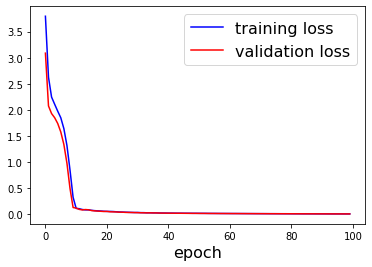

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(0,len(loss_train_list)), loss_train_list, '-b', label='training loss')
ax.plot(np.arange(0,len(loss_val_list)), loss_val_list, '-r', label='validation loss')
ax.set_xlabel('epoch',fontsize=16)
ax.legend(fontsize=16)

Usually, we need to tune the hyperparameters of a neural network, <br>
such as the number of layers, the number of units in each layer <br>
For this simple example, we can skip this step

after training, we evaluate the model on the testing dataset

In [24]:
loss_test, mae_test = test(model, dataloader_test, device)
print('test loss:', loss_test)

test loss: 0.006713001042604447


Get the predicted target values on the testing set

In [25]:
X_test_t=torch.tensor(X_test, dtype=torch.float32) #convert numpy array to torch tensor
#the input to model should be torch tensor
Yp_test_t=model(X_test_t.to(device))
type()

torch.Tensor

In [26]:
Yp_test=Yp_test_t.detach().cpu().numpy() #convert torch tensor to numpy array
type(Yp_test)

numpy.ndarray

plot Yp_test vs Y_test

In [28]:
Yp_test_t.shape

torch.Size([1000, 1])

In [29]:
Y_test.shape

(1000, 1)

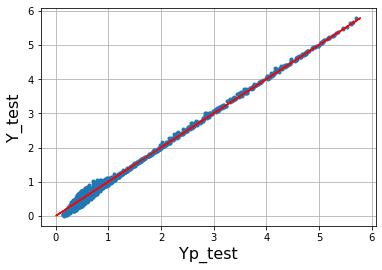

In [27]:
fig, ax = plt.subplots()
ax.plot(Yp_test, Y_test, '.')
ax.plot(Y_test, Y_test, 'r-')
ax.set_xlabel('Yp_test', fontsize=16)
ax.set_ylabel('Y_test', fontsize=16)
ax.grid(True)